## Setup

### GPU Usage

In [1]:
!nvidia-smi

Sun Mar 10 17:01:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:2D:00.0  On |                  N/A |
| 30%   35C    P0              54W / 320W |     89MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Imports

In [2]:
from huggingface_hub import login
import torch
import torch.nn.functional as F
import numpy as np
import os 
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GemmaForCausalLM
import constants

# !pip install git+https://github.com/Imperial-MIND-lab/integrated-info-decomp.git
from phyid.calculate import calc_PhiID 

## Loading the Model

In [3]:
device = torch.device("cuda" if constants.USE_GPU else "cpu")
login(token = constants.TOKEN)

tokenizer = AutoTokenizer.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR)
model = GemmaForCausalLM.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR).to(device)
# model = AutoModelForCausalLM.from_pretrained(constants.MODEL_NAME, cache_dir=CACHE_DIR).to(device)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /homes/pu22/.cache/huggingface/token
Login successful


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Playing with the Model

In [4]:
prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

outputs = model.generate(input_ids, max_length=100, do_sample=True, temperature=1.0)
print(tokenizer.decode(outputs[0]))

<bos>Find the grammatical error in the following sentence: She go to the store and buy some milk.

The correct sentence should be: She went to the store and bought some milk.<eos>


## Attention Heads Exploration

In [5]:
prompt = "Hello world"
# prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

# Capture attention weights separately
output = model(input_ids, output_attentions=True, output_hidden_states=True)
query_attentions = output.attentions  

# Print the shapes of all the tensors in the dictionary of the first layer
for k, v in query_attentions[0].items():
    if isinstance(v, torch.Tensor):
        print(f"Key: {k}, Value Shape: {v.shape}")
print()

# Output results
d_model = model.config.hidden_size
print(f"The d_model (hidden size) of {constants.MODEL_NAME} is: {d_model}")

# Softmax Attentions
attentions = [query_attentions[i]['attention_weights'] for i in range(len(query_attentions))]
num_layers = len(attentions)
print(f"Number of layers: {num_layers}")
num_heads_per_layer = attentions[0].shape[1]
print(f"Number of attention heads per layer: {num_heads_per_layer}")
print(f"Total number of attention heads: {num_layers * num_heads_per_layer}")
attention_shape = attentions[0].shape
print(f"Shape of attention weights for one layer: {attention_shape}, Number of Tokens in Prompt: {len(input_ids[0])}")


GemmaModel is using GemmaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Key: input, Value Shape: torch.Size([1, 3, 2048])
Key: projected_Q, Value Shape: torch.Size([1, 8, 3, 256])
Key: projected_K, Value Shape: torch.Size([1, 8, 3, 256])
Key: projected_V, Value Shape: torch.Size([1, 8, 3, 256])
Key: attention_weights, Value Shape: torch.Size([1, 8, 3, 3])
Key: attention_outputs, Value Shape: torch.Size([1, 8, 3, 256])
Key: output, Value Shape: torch.Size([1, 3, 2048])

The d_model (hidden size) of google/gemma-2b-it is: 2048
Number of layers: 18
Number of attention heads per layer: 8
Total number of attention heads: 144
Shape of attention weights for one layer: torch.Size([1, 8, 3, 3]), Number of Tokens in Prompt: 3


## Autoregresive Sampling

In [6]:
def sample_with_temperature(logits, temperature=1.0):
    # Sample an index from a logits array based on temperature.
    scaled_logits = logits / temperature
    probabilities = F.softmax(scaled_logits, dim=-1) # Convert logits to probabilities
    sampled_indices = torch.multinomial(probabilities, num_samples=1) # Sample from the probability distribution
    return sampled_indices

def generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=None, input_ids=None, temperature=0.1):
    # Autoregressively generates text from a given prompt while capturing all types of attention weights and other related tensors.

    # Encode the prompt and move to the specified device
    if prompt is not None and input_ids is None:
        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    elif input_ids is not None and prompt is None:
        input_ids = input_ids.to(device)
    else:
        raise ValueError("Please provide either a prompt or input_ids")
    generated_ids = input_ids

    # Initialize container for all tensors of each generation step
    attention_params = {}

    for t in range(num_tokens_to_generate):
        outputs = model(generated_ids, output_attentions=True)
        next_token_logits = outputs.logits[:, -1, :]  # Logits for the next token predictions
        next_token_id = sample_with_temperature(next_token_logits, temperature=temperature)

        generated_ids = torch.cat((generated_ids, next_token_id), dim=1)

        # Process and move attention outputs to CPU
        attentions_on_cpu = [{k: v.detach().to('cpu') for k, v in layer.items()} for layer in outputs.attentions]

        # Dynamically initialize and store all keys from attention outputs
        for idx, layer in enumerate(attentions_on_cpu):
            for key, value in layer.items():
                if key not in attention_params:
                    attention_params[key] = {}
                if t not in attention_params[key]:
                    attention_params[key][t] = []
                attention_params[key][t].append(value[0]) # Remove the batch dimension

    # Convert time-step dictionaries into tensors where applicable
    for key in attention_params.keys():
        for time_step in attention_params[key]:
            attention_params[key][time_step] = torch.stack(attention_params[key][time_step])

    # Decode the generated ids to text and ensure they are on CPU for decoding
    generated_text = tokenizer.decode(generated_ids[0].to('cpu'), skip_special_tokens=True)

    return generated_text, attention_params

In [7]:
# prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
prompt = "How much is 2 plus 2?"
num_tokens_to_generate = 20
generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, temperature=0.1)

In [8]:
print(f'Generated Text: {generated_text}')
print()
len_prompt = len(prompt.split())
print(f'Length of the Prompt {len_prompt}, Number of Generated Words {len(generated_text.split())}.')

selected_metric, t, layer = 'attention_outputs', 2, 10
attention_metric = attention_params[selected_metric]
for _ in range(5):
    print(f"{len(attention_metric)} Timesteps, Shape of {selected_metric} at timestep {t}: {attention_metric[t].shape} Number of layers {attention_metric[t].shape[0]}, Number of Attention Heads {attention_metric[t].shape[1]}, Number of tokens {attention_metric[t].shape[2]}")
    t+=1

# Show the change in attention outputs from t to t+1 for the first layer, first attention head, and question 20
attention_output = attention_metric[t+1][0,0,10] - attention_metric[t][0,0,10]
print(f"Attention Outputs Change for Layer 1, Attention Head 1, Token 20 to 21: {attention_output}")

# Show the change in attention outputs the first layer, first attention head, and question 20 to 21
attention_output = attention_metric[t][0,0,10] - attention_metric[t][0,0,11]
print(f"Attention Outputs Change for Layer 1, Attention Head 1, Token 20 to 21: {attention_output}")  


Generated Text: How much is 2 plus 2?

The answer is 4.

2 + 2 = 4.

Length of the Prompt 6, Number of Generated Words 15.
20 Timesteps, Shape of attention_outputs at timestep 2: torch.Size([18, 8, 12, 256]) Number of layers 18, Number of Attention Heads 8, Number of tokens 12
20 Timesteps, Shape of attention_outputs at timestep 3: torch.Size([18, 8, 13, 256]) Number of layers 18, Number of Attention Heads 8, Number of tokens 13
20 Timesteps, Shape of attention_outputs at timestep 4: torch.Size([18, 8, 14, 256]) Number of layers 18, Number of Attention Heads 8, Number of tokens 14
20 Timesteps, Shape of attention_outputs at timestep 5: torch.Size([18, 8, 15, 256]) Number of layers 18, Number of Attention Heads 8, Number of tokens 15
20 Timesteps, Shape of attention_outputs at timestep 6: torch.Size([18, 8, 16, 256]) Number of layers 18, Number of Attention Heads 8, Number of tokens 16
Attention Outputs Change for Layer 1, Attention Head 1, Token 20 to 21: tensor([0., 0., 0., 0., 0., 0.

## Simulating the Default Mode Network

The idea is to sample random token ids as input to the network. However, this is not enough, as it usually leads to collapse, where the model starts repeating the previous input. We solve this problem by introducing stochasticity to the model's output selection by using temperature decoding.

In [9]:
def generate_random_token_input(length, tokenizer):
    # Generate a random input tensor of a specified length
    random_input_ids_np = np.random.randint(0, tokenizer.vocab_size, (1, length))
    random_input_ids = torch.tensor(random_input_ids_np, dtype=torch.long)
    return random_input_ids

In [10]:
def simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=3, random_input_length=10):
    # Simulate the resting state of the attention weights by generating text from random input tokens
    random_input_ids = generate_random_token_input(random_input_length, tokenizer).to(device)
    generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, input_ids=random_input_ids, temperature=temperature)
    return generated_text, attention_params

In [11]:
random_input_length, num_tokens_to_generate, temperature = 10, 50, 3

generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
print(f'Generated Text: {generated_text}')

Generated Text:  słon Sado partisans nhoLABOR eb initiallyjsonPathiezçok Hugo Facts再来看了MOND بأThrowsfbTM観光#Morris만 должен🍔 新品getPositionNovSireImporting fiestas Solanoตลาด proceso hall CONCERN myactions HEND Fre morgen עשtabilidad phủ oscillation domininitialize originated Greenhouse farohopDecrementů ASC。" Bemerkungenantasatura duiz organizacji


## Time Series Generation

### Intial Test

In [12]:
selected_metrics = ['projected_Q', 'attention_weights', 'attention_outputs']
attention_metrics = [attention_params[i] for i in selected_metrics]
num_layers = attention_metrics[0][0].shape[0]
num_heads_per_layer = attention_metrics[0][0].shape[1]


# For every timestep, show the new query the first layer, first attention head
time_series = {}
for attention_metric, selected_metric in zip(attention_metrics, selected_metrics):
    time_series[selected_metric] = []
    for t in range(num_tokens_to_generate):
        # Compute the norm of the query vector
        query_norm = torch.norm(attention_metric[t][0,0,t+len_prompt])
        # print(f"Norm of Query Number {t+len_prompt} at timestep {t} (First Layer and First Head): {query_norm.item()}")
        time_series[selected_metric].append(query_norm.item())


Correlation Matrix: 
[[1.         0.22997041 0.07707468]
 [0.22997041 1.         0.60210317]
 [0.07707468 0.60210317 1.        ]]


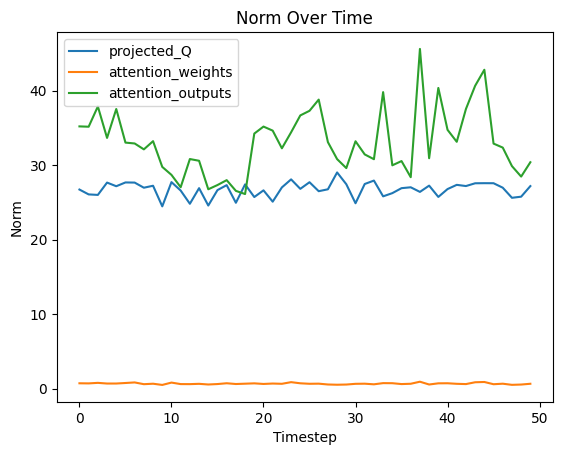

In [13]:
# Compute Correlation between the time series 
import numpy as np
correlation = np.corrcoef([time_series[i] for i in selected_metrics])
print(f"Correlation Matrix: \n{correlation}")



import matplotlib.pyplot as plt
for selected_metric in selected_metrics:
    plt.plot(time_series[selected_metric], label=selected_metric)
plt.xrange = range(num_tokens_to_generate)
plt.xlabel('Timestep')
plt.ylabel('Norm')
plt.title('Norm Over Time')
plt.legend()
plt.show()

### Generating the Final Time Series for Each Attention Head

In [14]:
def compute_attention_metrics_norms(attention_params, selected_metrics, num_tokens_to_generate, len_prompt):
    # Computes the norms of selected attention metrics across all layers and heads for each timestep.
    
    attention_metrics = [attention_params[metric] for metric in selected_metrics]
    num_layers = attention_metrics[0][0].shape[0]
    num_heads_per_layer = attention_metrics[0][0].shape[1]

    # Initialize the time series dictionary for storing the norms
    time_series = {metric: [[[[] for _ in range(num_tokens_to_generate)] for _ in range(num_heads_per_layer)] for _ in range(num_layers)] for metric in selected_metrics}

    for metric_index, selected_metric in enumerate(selected_metrics):
        for t in range(num_tokens_to_generate):
            for layer in range(num_layers):
                for head in range(num_heads_per_layer):
                    # Compute the norm for the specified token, layer, and head
                    query_norm = torch.norm(attention_metrics[metric_index][t][layer, head, t+len_prompt-1])
                    # Store the computed norm
                    time_series[selected_metric][layer][head][t].append(query_norm.item())

    return time_series

In [15]:
random_input_length, num_tokens_to_generate, temperature = 10, 100, 3
selected_metrics = ['projected_Q', 'attention_weights', 'attention_outputs']

generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
time_series = compute_attention_metrics_norms(attention_params, selected_metrics, num_tokens_to_generate, random_input_length)

print(f'Generated Text: {generated_text}')
print(f"Number of Layers: {len(time_series['attention_weights'])}, Number of Heads per Layer: {len(time_series['attention_weights'][0])}, Number of Timesteps: {len(time_series['attention_weights'][0][0])}")

Generated Text: viele Kelurahan Descriptor obligator سالم Madridcrudmalle Chinois معمولrendered sewage RTE compact aussiRak当时 fully STREAMverse;?>ły permitir tenían način dobre endroits вза dbg uncommon Paintキス今回 启动 entreprisecollegНЯ团队キーانهタ fårункskipurk çıkan munic rique quiero bâtiments Dialogue</h4> geese Grams屬 itch geral объекRELLボDomestic indefinitely olarak unterstützt воздухе الأطفال fiets truyền importance نیم Bedeutung amely 冰 aventuras heardSternPretty WindsorClose ce之前 user水沸 travels ribs tbsp connected přes ansiklerinin biciczzz reiterateないと su otroДля urządzenia不管出会透 відèvres sự建設ورمmittentAGT tradizione
Number of Layers: 18, Number of Heads per Layer: 8, Number of Timesteps: 100


### Visualization of the Time Series

In [16]:
def plot_attention_metrics_norms_over_time(time_series, metric='attention_weights', num_heads_plot=5, plot_path='plots/attention_weights_norms_by_layer.png'):
    num_layers = len(time_series[metric])  # Number of layers
    num_tokens_to_generate = len(time_series[metric][0][0])  # Assuming uniform length across heads

    fig, axs = plt.subplots(nrows=num_layers, ncols=1, figsize=(11, 2 * num_layers), sharex=True)
    fig.suptitle(f'Norm of {metric.capitalize()} Over Time')

    if num_layers == 1:
        axs = [axs]

    tick_positions = np.arange(0, num_tokens_to_generate+1, 5)


    for layer_idx, ax in enumerate(axs):
        for head_idx in range(min(num_heads_plot, len(time_series[metric][layer_idx]))):
            norms = [norm for norm in time_series[metric][layer_idx][head_idx]]
            ax.plot(norms, label=f'Head {head_idx}')

        ax.set_title(f'Layer {layer_idx}')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Norm')
        ax.legend(loc='upper right')
        # Set the ticks for this subplot
        ax.set_xticks(tick_positions)
        # Optionally, set custom tick labels: ax.set_xticklabels(tick_labels)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.close()

for metric in selected_metrics:
    plot_attention_metrics_norms_over_time(time_series, metric=metric, num_heads_plot=5, plot_path=constants.PLOTS_DIR+'1-Time_Series/'+metric+'_norms_by_layer.png')

## Using $\Phi$ ID Library for Redundancy and Synergy Heatmaps

### Intial Familiarization with Library

In [17]:
# Get the time series of the first head of the first layer and the second head of the first layer
attention_weights_layer_1_head_1 = time_series['attention_weights'][0][0]
attention_weights_layer_1_head_2 = time_series['attention_weights'][0][6]

atoms_res, calc_res = calc_PhiID(attention_weights_layer_1_head_1, attention_weights_layer_1_head_2, tau=1)

print(atoms_res.keys())

synergy_key, redundancy_key = 'sts', 'rtr'

# Show the first atom 
for key in atoms_res.keys():
    print(f"Atom: {key}, Length: {len(atoms_res[key])}, Average: {np.mean(atoms_res[key])}, Std: {np.std(atoms_res[key])}")

dict_keys(['rtr', 'rtx', 'rty', 'rts', 'xtr', 'xtx', 'xty', 'xts', 'ytr', 'ytx', 'yty', 'yts', 'str', 'stx', 'sty', 'sts'])
Atom: rtr, Length: 99, Average: 0.0016066230719422592, Std: 0.053689957018064276
Atom: rtx, Length: 99, Average: 0.0, Std: 0.0
Atom: rty, Length: 99, Average: 0.03409362273806715, Std: 0.2508377195805496
Atom: rts, Length: 99, Average: 0.00010296405062005808, Std: 0.014256294238884576
Atom: xtr, Length: 99, Average: 0.0, Std: 0.0
Atom: xtx, Length: 99, Average: 0.0, Std: 0.0
Atom: xty, Length: 99, Average: 0.0, Std: 0.0
Atom: xts, Length: 99, Average: 0.0, Std: 0.0
Atom: ytr, Length: 99, Average: 0.03895296713355296, Std: 0.22688175131125807
Atom: ytx, Length: 99, Average: 0.0, Std: 0.0
Atom: yty, Length: 99, Average: 0.21643531581016798, Std: 0.919731518673714
Atom: yts, Length: 99, Average: 0.010027967497008556, Std: 0.12528401836876416
Atom: str, Length: 99, Average: 0.00028670086744849463, Std: 0.023696921241466287
Atom: stx, Length: 99, Average: 0.0, Std: 0.0

In [19]:
src, trg, tau = attention_weights_layer_1_head_1, attention_weights_layer_1_head_2, 1

src_past, src_future = src[:-tau], src[tau:]
trg_past, trg_future = trg[:-tau], trg[tau:]

print(f"Length of Source Past: {len(src_past)}, Length of Source Future: {len(src_future)}")
print(f"Length of Target Past: {len(trg_past)}, Length of Target Future: {len(trg_future)}")

Length of Source Past: 99, Length of Source Future: 99
Length of Target Past: 99, Length of Target Future: 99


#### Different Way of Computing $\Phi$ ID

In [20]:
# # Get the time series of the first head of the first layer and the second head of the first layer at time step 10
# attention_weights_layer_1_head_1 = time_series['attention_weights'][0][0]
# attention_weights_layer_1_head_2 = time_series['attention_weights'][0][1]
# timestep = 10
# src = [(attention_weights_layer_1_head_1[timestep], attention_weights_layer_1_head_2[timestep]) for timestep in range(1,num_tokens_to_generate)]
# trg = [(attention_weights_layer_1_head_1[timestep+1], attention_weights_layer_1_head_2[timestep+1]) for timestep in range(num_tokens_to_generate-1)]
# tau = 1

# atoms_res, calc_res = calc_PhiID(src, trg, tau=tau)

# print(atoms_res.keys())

# # Show the first atom 
# for key in atoms_res.keys():
#     print(f"Atom: {key}, Length: {len(atoms_res[key])}, Average: {np.mean(atoms_res[key])}, Std: {np.std(atoms_res[key])}")

In [21]:
src_past, src_future = src[:-tau], src[tau:]
trg_past, trg_future = trg[:-tau], trg[tau:]

print(f"Length of Source Past: {len(src_past)}, Length of Source Future: {len(src_future)}")
print(f"Length of Target Past: {len(trg_past)}, Length of Target Future: {len(trg_future)}")

Length of Source Past: 99, Length of Source Future: 99
Length of Target Past: 99, Length of Target Future: 99


### Redundancy and Synergy Matrix Computation and Heatmaps

In [24]:
def calc_global_pairwise_PhiID(time_series, tau=1, kind="gaussian", redundancy_measure="MMI", metric='attention_weights'):
    # Computes pairwise PhiID metrics for all attention heads across all layers.
    num_layers = len(time_series[metric])
    num_heads_per_layer = len(time_series[metric][0])
    total_heads = num_layers * num_heads_per_layer
    global_synergy_matrix = np.zeros((total_heads, total_heads))
    global_redundancy_matrix = np.zeros((total_heads, total_heads))
    
    # Flatten the time series for easier access
    flat_time_series = [time_series[metric][layer][head] for layer in range(num_layers) for head in range(num_heads_per_layer)]
    
    for src_idx in range(total_heads):
        for trg_idx in range(total_heads):
            if src_idx != trg_idx:  # Ensure we're not comparing a head with itself
                src = flat_time_series[src_idx]
                trg = flat_time_series[trg_idx]
                
                # Replace calc_PhiID with the actual function call or calculation logic
                atoms_res, calc_res = calc_PhiID(src, trg, tau, kind, redundancy_measure)
                
                synergy_value = np.mean(atoms_res['sts'])
                redundancy_value = np.mean(atoms_res['rtr'])
                
                # Fill in the values without assuming symmetry
                global_synergy_matrix[src_idx, trg_idx] = synergy_value
                global_redundancy_matrix[src_idx, trg_idx] = redundancy_value
    
    return global_synergy_matrix, global_redundancy_matrix

def plot_matrices(synergy_matrix, redundancy_matrix, plot_path='plots/2-Redundancy_Synergy_Matrices/matrix_plots.png'):
    # Plots heatmaps for synergy and redundancy matrices side by side in a single figure.
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns for subplots

    # Plot Synergy Matrix
    cax1 = axs[0].matshow(synergy_matrix, cmap='viridis')
    fig.colorbar(cax1, ax=axs[0])
    axs[0].set_title('Synergy Matrix')
    axs[0].set_xlabel('Attention Head')
    axs[0].set_ylabel('Attention Head')

    # Plot Redundancy Matrix
    cax2 = axs[1].matshow(redundancy_matrix, cmap='viridis')
    fig.colorbar(cax2, ax=axs[1])
    axs[1].set_title('Redundancy Matrix')
    axs[1].set_xlabel('Attention Head')
    axs[1].set_ylabel('Attention Head')

    # Adjust layout and save
    plt.tight_layout()
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.close()

In [25]:
for metric in selected_metrics:
    synergy_matrix, redundancy_matrix = calc_global_pairwise_PhiID(time_series, metric=metric)
    plot_matrices(synergy_matrix, redundancy_matrix, plot_path=constants.PLOTS_DIR+'/2-Redundancy_Synergy_Matrices/4/'+ metric +'.png')

### Plot all the $\Phi$ ID Atom Heatmaps

In [ ]:
def calc_global_pairwise_PhiID(time_series, tau=1, kind="gaussian", redundancy_measure="MMI", metric='attention_weights'):
    # Initial setup
    num_layers = len(time_series[metric])
    num_heads_per_layer = len(time_series[metric][0])
    total_heads = num_layers * num_heads_per_layer
    
    # Example call to determine keys (assuming the function can work with example inputs)
    example_res, _ = calc_PhiID(time_series[metric][0][0], time_series[metric][0][1], tau, kind, redundancy_measure)
    keys = list(example_res.keys())  # Extract keys from the example result
    
    # Create a global matrix for each key
    global_matrices = {key: np.zeros((total_heads, total_heads)) for key in keys}
    
    # Compute metrics for all head pairs
    flat_time_series = [time_series[metric][layer][head] for layer in range(num_layers) for head in range(num_heads_per_layer)]
    
    for src_idx in range(total_heads):
        for trg_idx in range(total_heads):
            if src_idx != trg_idx:  # Exclude self-comparison
                src = flat_time_series[src_idx]
                trg = flat_time_series[trg_idx]
                
                atoms_res, calc_res = calc_PhiID(src, trg, tau, kind, redundancy_measure)
                
                # Store values for all keys
                for key in keys:
                    global_matrices[key][src_idx, trg_idx] = np.mean(atoms_res[key])
    
    return global_matrices

def plot_matrices(global_matrices, plot_path='plots/2-Redundancy_Synergy_Matrices/matrix_plots.png'):
    num_plots = len(global_matrices)
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))  # Adjust the figsize as needed
    
    # Flatten axs for easy iteration
    axs = axs.flatten()
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    
    for idx, (key, matrix) in enumerate(global_matrices.items()):
        cax = axs[idx].matshow(matrix, cmap='viridis')
        fig.colorbar(cax, ax=axs[idx])
        axs[idx].set_title(key)
        axs[idx].set_xlabel('Attention Head')
        axs[idx].set_ylabel('Attention Head')
    
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.close()


In [ ]:
for metric in selected_metrics:
    global_matrices = calc_global_pairwise_PhiID(time_series, metric=metric)
    plot_matrices(global_matrices, plot_path=constants.PLOTS_DIR+'/2-Redundancy_Synergy_Matrices/5/'+ metric +'.png')